In [1]:
import tifffile as tf
import pandas as pd
import numpy as np
from skimage.transform import hough_circle, hough_circle_peaks
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from skimage.filters import gaussian
from skimage.draw import circle_perimeter
from skimage.morphology import dilation,disk
from time import sleep
import cv2

In [2]:
def create_bin_edges(image,n=3,alpha=1):
    bin_image = np.zeros_like(image)
    # threshold = threshold_otsu(images[1])
    threshold = np.median(image)+ n*np.std(image)
    bin_image[image> threshold ] = 1
    bin_image[image > threshold+alpha*np.std(image)]=0
    return bin_image

In [3]:
def clip_detections(accums,cx,cy,radii,N=8):
    accums = accums[:N]
    cx = cx[:N]
    cy = cy[:N]
    radii = radii[:N]
    return accums,cx,cy,radii


In [4]:
def dilate_detected_edges(img,r = 3):
    #dilates the thin edges found in membrane
    kernel = disk(r)
    return dilation(img,kernel)

In [5]:
def find_duplicates(cxcy):
    #cxcy -> ndarray of shape (N_detections,2): initial detected centre coordinates of circles
    
    for i in range(cxcy.shape[0]):
        peak = cxcy[i]
        rest  = cxcy[i+1:]

        dists = np.linalg.norm(rest - peak,axis = 1)
        if i == 0:

            multi_detections = np.nonzero(dists < 20)[0] +i+1
            
        else:
            multi_detections = np.concatenate((multi_detections,np.nonzero(dists < 20)[0]+i+1))

            
    return np.unique(multi_detections)

    

In [6]:
def remove_duplicates(accum,cx,cy,radii,duplicate_coords):
    #accum -> 1darray: ordered results of voting on hough circles
    #cx -> 1darray: most likely x coords by voting
    #cy -> 1darray: most likely y coords by voting
    #duplicate_coords -> 1darray: indices of duplicate detections to remove
    
    accum = np.delete(accum,duplicate_coords)
    cx = np.delete(cx,duplicate_coords)
    cy = np.delete(cy,duplicate_coords)
    radii = np.delete(radii,duplicate_coords)
    return accum,cx,cy,radii

In [7]:

def segment_detections(image,hough_vals):
    #image -> ndarray (512,512): raw image 
    #hough_vals -> tuple of 4 1d_arrays : post processed hough circle detection
    ##############  (accumulator,c_x,c_y,radii)
    
    
    detections_img  = np.zeros_like(image)
    i = 1
    for x,y, rad in zip(hough_vals[1],hough_vals[2],hough_vals[3]):

        circy,circx = circle_perimeter(y,x,rad)
        detections_img[circy[circx < 512][circy[circx <512] < 512],circx[circx < 512][circy[circx<512] < 512]] = i
        i +=1
    # plt.imshow(images[1])
    # plt.imshow(detections_img,alpha=1)

    return detections_img




In [54]:
def detect_guvs(image,radii,N,n,sigma = 2,alpha = 1,rel_hough_peak_threshold = 0.3):
    #########################################
    #image, (512x512) ndarray: Numpy representation of tif image. fluorescence confocal microscopy image of GUVs
    #radii, 1darray: array of candidate radii passed to Hough detection to find circles in the image within this range
    #N, int: max number of detections per image
    #n, int: level of thresholding during binarisation
    #sigma int: determines the amount of smoothing in the gaussian smoothing function
    #alpha int: maximum intensity level for membrane fluorescence. This sets a maximum level above which pixels are removed from the foreground
    #########################################
    #Returns: instances of detected GUVs, ndarray (512,512) and hough_vals: voting accumulation,cx,cy,radii of detected GUVs
    #########################################
    
    
    
    #Instantiate ax
    #ax = get_ax()
    
    #add_to_display(ax,image,'image')
    #smooth the image first
    smoothed_image = gaussian(image,sigma)
    #create binary edges for circle detection
    
    #add_to_display(ax,smoothed_image,'smoothed')
    
    bin_image = create_bin_edges(image,n,alpha)
    #plt.imshow(bin_i'multi_detections'mage)
    #circle detection with Hough transform
    #add_to_display(ax,bin_image,'binary')
    
    hough_res = hough_circle(bin_image,radii)

    #print(hough_res.shape)
    #sleep(10)
    detection_transform = np.sum(hough_res,axis = 0)
    
    hough_vals = hough_circle_peaks(hough_res,radii,threshold=0.3*np.max(hough_res))

    #clip detections: we don't expect there to be more than a few GUVs in one frame

    hough_vals = clip_detections(*hough_vals,N)

    #reshape the peak coordinates to exploit some numpy optimizations

    cxcy = np.vstack((hough_vals[1],hough_vals[2])).T


    #Due to bug in scikit image hough circle peaks function, need to remove duplicates

    duplicates = find_duplicates(cxcy)

    hough_vals = remove_duplicates(*hough_vals,duplicates)

    #Segment instances of circles to get individual GUV membranes

    detections_img = segment_detections(image,hough_vals)
            
    detections_img = dilate_detected_edges(detections_img)
    #add_to_display(ax,detections_img,'Hough')
    #plt.show()
    
    return detections_img,hough_vals,detection_transform

# Get the average flow of GUV positions between frames
## We do this to make a prediction of the change in position of the GUVs between frame

In [9]:
def get_ave_pos(cx,cy):
    ##########################
    #cx (N,) 1darray: x positions of detected GUVs
    #cy (N,) 1darray: y positions of detected GUVs
    ##########################
    #Returns: cxy_hat (1,2) 1darray: average position of detected GUVs
    
    cx_hat = np.average(cx)
    print(cx_hat)
    cx_hat = int(cx_hat)
    
    
    cy_hat = np.average(cy)
    print(cy_hat)
    cy_hat = int(cy_hat)
    
    cxcy = np.array([cx_hat,cy_hat])
    return cxcy

In [10]:
def get_drift(cx_t2,cy_t2,cxy_hat_t1):
    #######################################
    #cx_t2, 1D numpy array (N,): x coordinates of detected GUV centres output from Hough algorithm in frame t
    #cy_t2, 1D numpy array (N,): y coordinates of detected GUV centres output from Hough algorithm in frame t
    #cxy_hat_t1, 1D numpy array (2,): average position of GUVs in frame t-1
    
    #######################################
    #Returns: drift vector between frame t and t-1, average x,y position vector of GUVs
    
    cx_hat = np.average(cx_t2)
    cx_hat = int(cx_hat)
    #print(cx_hat)
    cy_hat = np.average(cy_t2)
    cy_hat = int(cy_hat)
    #print(cy_hat)
    cxy_hat_t2 = np.array([cx_hat,cy_hat])
    deltaxy_hat = cxy_hat_t2 - cxy_hat_t1
    
    return deltaxy_hat,cxy_hat_t2

    

In [11]:
def add_drift(cx,cy,cxy_hat):
    return cx + cxy_hat[0],cy +cxy_hat[1]


In [12]:
def collate_guv_vectors(cx,cy,radii):
    ############################################
    #cx_t2, 1D numpy array (N,): x coordinates of detected GUV centres output from Hough algorithm in frame t
    #cy_t2, 1D numpy array (N,): y coordinates of detected GUV centres output from Hough algorithm in frame t
    
    #cx_t1, 1D numpy array (N,): x coordinates of detected GUV centres output from Hough algorithm in frame t - 1
    #cy_t1, 1D numpy array (N,): y coordinates of detected GUV centres output from Hough algorithm in frame t - 1
    
    #etc for radii
    
    ###########################################
    #Returns: list of 3D vectors,(cx,cy,radius) for each time point. Points in this vector space represent the GUV state. They are compared to identify the guvs
    
    
    guv= np.vstack((cx,cy,radii)).T

    return guv

In [13]:
def diff_t2_t1(guv_t2,guv_t1_inst,sigmaL=15,sigmaR=2):
    #######################################
    #guv_t2 (N2,3) ndarray: List of guv state vectors for all new detections
    #guv_t1_inst(1,3) ndarray: single guv state vector for the guv to be tracked between t-1 and t
    #######################################
    
    deltas = guv_t2 - guv_t1_inst
    deltas_square = deltas*deltas

    probabilities = np.exp(-1*np.sum(deltas_square[:,:2],axis =1)/sigmaL**2)*(np.exp(-1*deltas_square[:,2]/sigmaL**2))

    return probabilities
    

In [14]:
def record_guvs(guv_t1):
    ###############################
    #guv_t1 (N,3) ndarray: array of 3D 'state' vectors for each guv (x,y,R)
    ###############################
    #Returns: dict, keys label the guvs with their state vector and the confidence level that this is the state for this guv label
    
    guv_states = {}
    for n in range(guv_t1.shape[0]):
        guv_states[str(n)] = [guv_t1[n],1]
        
    return guv_states
        

In [28]:
def draw_labels(positions,guv_states,detections_img):
    ##############################
    #guv_states dict -> [guv state,confidence]: active guv states. states are defined as a 3D vector (x,y,R)
    #positions dict -> [cx,cy]: centre coordinates to draw label
    #detections_img (512,512) ndarray: image of detected circle instances
    #############################
    #Returns: detected instances labelled.
    
    
    
    #use cv2 to add test to the actual image
      
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 

    # org 
    org = (50, 50) 

    # fontScale 
    fontScale = 1

    # Blue color in BGR 
    color = (40, 0, 0) 

    # Line thickness of 2 px 
    thickness = 2
       
    # Using cv2.putText() method 
    for  key in positions.keys():
        
        detections_img = cv2.putText(detections_img,key+', '+str(guv_states[key][1])[:4] , (positions[key][0],positions[key][1]), font,  
                       fontScale, color, thickness, cv2.LINE_AA)
 
    #fig,ax = plt.subplots(1,2)
    #ax[0].imshow(image)
    #ax[1].imshow(detections_img)
    #for key in positions.keys():
       
    #    ax[1].text(positions[key][0],positions[key][1],key+', '+str(guv_states[key][1])[:4],fontsize=12,c='r')
    #plt.show()
    return detections_img

In [16]:
def image_to_rel_coords(guv_states):
    ################################
    #guv_states dict -> [guv state,confidence]: active guv states. states are defined as a 3D vector (x,y,R)
    ################################
    #Returns: relative coordinates of guv centre, for plt.text function in matpotlib
    positions = {}
    
    for key in guv_states.keys():
        positions[key] = [guv_states[key][0][0],guv_states[key][0][1]]
    
    return positions

In [17]:
def propagate_in_time(guv_states,guvs_t2,min_confidence=0.7):
    ###############################################
    #guv_states dict -> [guv state,confidence]: active guv states. states are defined as a 3D vector (x,y,R)
    #guvs_t2 -> guv_state (N,3) ndarray: new detections in frame at t = t2
    ################################################
    #returns: new guv active state record with their confidences
    
    
    keys_to_remove = []
    for guv_key in guv_states.keys():
        #print(guv_states[guv_key])
        guv_t1 = guv_states[guv_key][0]

        probabilities = diff_t2_t1(guvs_t2,guv_t1,sigmaL=30,sigmaR=2)

        #only consider closeby detections for identification of guv between frames
        candidates = guvs_t2[probabilities > min_confidence]
        #print(candidates)
        probabilities = probabilities[probabilities > min_confidence]

        #if close by guvs meet threshold then update guv states
        if candidates.shape[0] > 0:
            confidence = probabilities[probabilities == np.max(probabilities)][0]
            guv_state = candidates[probabilities == np.max(probabilities)][0]
            guv_states[guv_key] = [guv_state,confidence]

        else:
            print('GUV lost')
            # if a GUV is lost we have to decide what to do with the time trace. we delete its label from the active states
            keys_to_remove.append(guv_key)



    for key in keys_to_remove:
        del guv_states[key]
        
    return guv_states


In [37]:
def uint162uint8(image):
    image = image/np.max(image)
    image = 255*image
    return image.astype(np.uint8)

In [18]:
vid_directory = '../Downloads'
vid_name = 'Image0004.tif'
tif = tf.TiffFile(vid_directory+'/'+vid_name)

#nbd and liss Rhod frames separate by half the frame length of video

images = tif.asarray()

In [56]:
%matplotlib qt
#configurations

radii = np.arange(10,35,1)
N = 100
min_confidence = 0.7
rel_hough_peak_threshold = 0.3
#fig,ax = plt.subplots(1,2)

#prepare video encoder and open file

# fourcc = cv2.VideoWriter_fourcc(*'MJPG')
# out = cv2.VideoWriter('./detections.avi',fourcc,24,(512,512))

for i in range(20):
    #grab frame
    image = images[1][499+i]

    #use hough circles to detect guvs
    
    detection_img,hough_vals,transform = detect_guvs(image,radii,N,2)

    if i ==0:
        #separate hough return values into useful arrangements
        #detections_img1 = detection_img.copy()
        cx_t1 = hough_vals[1]
        cy_t1 = hough_vals[2]
        radii_t1 = hough_vals[3]

        guvs_t1 = collate_guv_vectors(cx_t1,cy_t1,radii_t1)
        guv_states = record_guvs(guvs_t1)
        
        positions = image_to_rel_coords(guv_states)
        
    else:
        #after the first frame we have initial positions for guvs.
        #we now start the tracking process
        #detections_img2 = detection_img.copy()        
        #separate hough return values into useful arrangements

        cx_t2 = hough_vals[1]
        cy_t2 = hough_vals[2]
        radii_t2 = hough_vals[3]    
        
        guvs_t2 = collate_guv_vectors(cx_t2,cy_t2,radii_t2)
        
        guv_states =propagate_in_time(guv_states,guvs_t2,min_confidence)
        
        positions = image_to_rel_coords(guv_states)
        
        labelled_detection_img = draw_labels(positions,guv_states,detection_img)
    
        frame = uint162uint8(labelled_detection_img)
        transform = uint162uint8(transform)
#         out.write(frame)
        i = str(i)
        if len(i)==2:
            i = '0'+i
        elif len(i) == 1:
            i = '00'+i
        else:
            i = i
        cv2.imwrite('GUVs_frame_0'+i+'.png',transform)
# out.release()
    

    #sleep(1)


GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost
GUV lost


In [51]:
print(hough_re

(18,)


In [49]:
images.shape

(2, 618, 512, 512)

In [15]:
image1 = images[1][499]
image2 = images[1][500]

In [32]:
out = cv2.VideoWriter('./detections.avi',-1,24,(512,512))

<VideoWriter 0x7f0f9ecf6290>

In [76]:
_,hough_vals1 = detect_guvs(image1,radii,N,2)
detection_img,hough_vals2 = detect_guvs(image2,radii,N,2)

cx_t2 = hough_vals2[1]
cy_t2 = hough_vals2[2]
radii_t2 = hough_vals2[3]

cx_t1 = hough_vals1[1]
cy_t1 = hough_vals1[2]
radii_t1 = hough_vals1[3]

In [55]:
print(cx_t2,cy_t2)
print(cx_t1,cy_t1)

[184 127  58  86 224 467 379 245 225 374  36] [202 380 291 246  33  97 132 292 306  11 254]
[187 129  87  60 381 225 469 243 374] [203 379 250 291 133  34  98 290  12]


In [52]:
cxcy_hat_t1 = get_ave_pos(cx_t1,cy_t1)
delta,cxcy_hat_t2 = get_drift(cx_t2,cy_t2,cxcy_hat_t1)

239.44444444444446
187.77777777777777
218
204


In [61]:
guvs_t2 = collate_guv_vectors(cx_t2,cy_t2,radii_t2)
guvs_t1 = collate_guv_vectors(cx_t1,cy_t1,radii_t1)

In [62]:
guv_states = record_guvs(guvs_t1)

In [63]:
min_confidence = 0.7
keys_to_remove = []
for guv_key in guv_states.keys():
    print(guv_states[guv_key])
    guv_t1 = guv_states[guv_key][0]
    
    probabilities = diff_t2_t1(guvs_t2,guv_t1,sigmaL=8,sigmaR=1)
    
    #only consider closeby detections for identification of guv between frames
    candidates = guvs_t2[probabilities > 0.7]
    print(candidates)
    probabilities = probabilities[probabilities > 0.7]
    
    #if close by guvs meet threshold then update guv states
    if candidates.shape[0] > 0:
        confidence = probabilities[probabilities == np.max(probabilities)]
        guv_state = candidates[probabilities == np.max(probabilities)]
        guv_states[guv_key] = [guv_state,confidence]
        
    else:
        print('GUV lost')
        # if a GUV is lost we have to decide what to do with the time trace. we delete its label from the active states
        keys_to_remove.append(guv_key)
        
    
        
for key in keys_to_remove:
    del guv_states[key]
    
    
    

[array([187, 203,  24]), 1]
[[184 202  26]]
[array([129, 379,  22]), 1]
[[127 380  24]]
[array([ 87, 250,  24]), 1]
[[ 86 246  26]]
[array([ 60, 291,  20]), 1]
[[ 58 291  20]]
[array([381, 133,  20]), 1]
[[379 132  20]]
[array([225,  34,  26]), 1]
[[224  33  28]]
[array([469,  98,  20]), 1]
[[467  97  22]]
[array([243, 290,  20]), 1]
[]
GUV lost
[array([374,  12,  30]), 1]
[[374  11  30]]


In [64]:
print(guv_states)

{'0': [array([[184, 202,  26]]), array([0.80352257])], '1': [array([[127, 380,  24]]), array([0.86881506])], '2': [array([[ 86, 246,  26]]), array([0.72027298])], '3': [array([[ 58, 291,  20]]), array([0.93941306])], '4': [array([[379, 132,  20]]), array([0.92484881])], '5': [array([[224,  33,  28]]), array([0.91051036])], '6': [array([[467,  97,  22]]), array([0.86881506])], '8': [array([[374,  11,  30]]), array([0.98449644])]}


In [86]:
positions = image_to_rel_coords(guv_states)

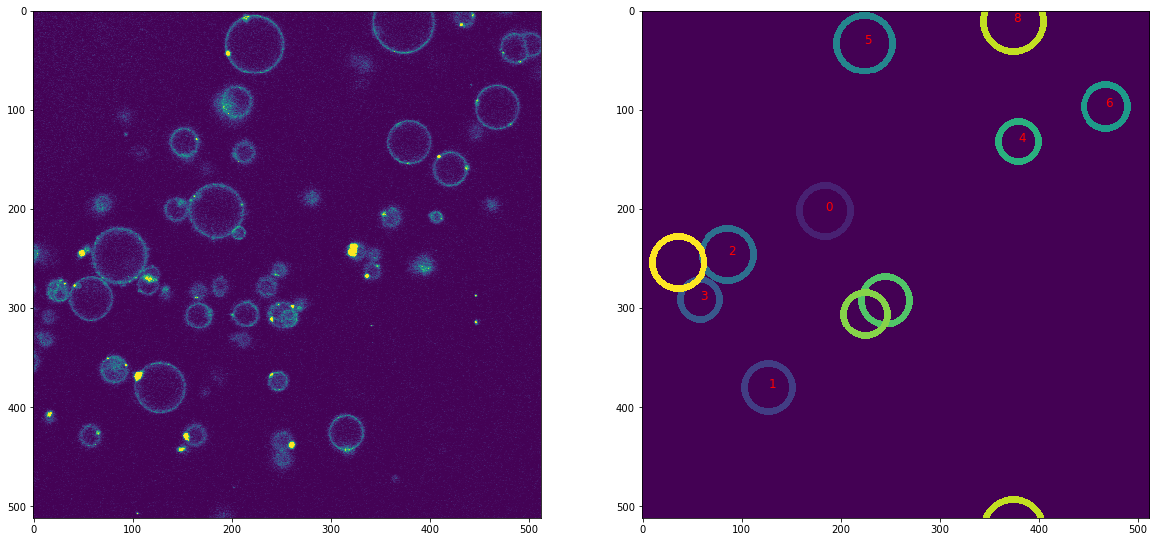

TypeError: draw_labels() missing 5 required positional arguments: 'fig', 'ax', 'positions', 'image', and 'detections_img'

In [93]:
fig,ax = plt.subplots(1,2)

draw_labels(fig,ax,positions,image2,detection_img)
